# Symulacja kosztów i efektów kampanii marketingowej Google Ads z wykorzystaniem metody Monte Carlo

<p></p>
<p>Według danych Głównego Urzędu Statystycznego, <a href=https://www.forbes.pl/pierwszy-milion/masz-tylko-30-procent-szans-na-sukces-jaki-zalozyc-biznes/2jwk3np>70% przedsiębiorstw upada</a> w ciągu pierwszych 5 lat od założenia, z czego 25-30% firm na rynku nie jest w stanie przetrwać nawet 12 miesięcy. Jedną z przyczyn takiego stanu rzeczy może być brak odpowiedniego rozeznania przed rozpoczęciem działalności, na przykład w kwestii wysokości koniecznych do poniesienia inwestycji czy też liczby potencjalnych klientów, którzy będą skłonni kupić nasz produkt bądź usługę, a także ponawiać swoje zakupy w przyszłości. Jednakże wartościowa analiza może sama w sobie okazać się trudnym wyzwaniem. By odpowiednio przygotować się do otwarcia sklepu internetowego bądź wprowadzenia produktu do sprzedaży, proces planowania powinien rozpocząć się od analizy informacji i danych pochodzących z różnych źródeł, np. dotyczących preferencji konsumentów, zmian cen surowców czy kosztów reklamy na przestrzeni ostatnich lat. Takie podejście ma jednak swoje wady. Po pierwsze, proces ten może dla większości małych i średnich przedsiębiorstw okazać się zbyt kosztowny. Po drugie, znalezienie i zebranie przydatnych danych będzie czasochłonne. Znacznie szybszym i tańszym rozwiązaniem jest podejście symulacyjne. Pozwala ono w stosunkowo prosty sposób wygenerować dane imitujące przebieg funkcjonowania przedsiębiorstwa na rynku i, dzięki oparciu się na odpowiednich zależnościach statystycznych, dostarczyć cennych informacji w kontekście podjęcia decyzji o rozpoczęciu działalności.</p>
<p>Celem niniejszego projektu jest dokonanie oszacowania jednych z podstawowych wskaźników, jakimi kierować się powinny wchodzące na rynek firmy, a mianowicie wartości życia klienta <i>Customer Lifetime Value</i> (CLTV) oraz kosztów pozyskania klienta <i>Customer Acquisition Cost</i> (CAC). Symulacja dokonana zostanie z perspektywy średniej wielkości przedsiębiorstwa, zainteresowanego rozpoczęciem kampanii marketingowej w systemie reklamowym <b>Google Ads</b>, pozwalającym na wyświetlanie linków sponsorowanych w wynikach wyszukiwania wyszukiwarki Google i na stronach współpracujących w ramach programu Google AdSense. Do celów badania, zakładany koszt inwestycji to 50 000 złotych, a analiza dotyczyć będzie pierwszych 5 lat działalności firmy.</p>

## Opis przebiegu symulacji

<p>Przed rozpoczęciem programowania przydatnych funkcji, konieczne jest zaimportowanie właściwych bibliotek, które dostarczą losowych wartości z odpowiednich rozkładów, a także pozwolą przechowywać dane w ramce danych i przedstawić je w formie graficznej.</p>

In [1]:
using Random, Distributions, PyPlot, DataFrames

<p>Poniższa funkcja wprowadza element losowy do zakładanego wskaźnika konwersji, czyli stosunku dokonanych zakupów do liczby wyświetleń reklamy witryny teoretycznego sklepu internetowego w wyszukiwarce Google. Dokonano założenia, że wskaźnik konwersji ma rozkład normalny, a także zabezpieczono się przed uzysykiwaniem wartości niedodatnich, gdyż w rzeczywistości wskaźnik konwersji nie może być mniejszy niż zero.</p>

In [3]:
function get_conversion_rate(expected, stdev)
    conversion_rate = maximum(expected + randn()*stdev)
    if conversion_rate <= 0
        conversion_rate = 0.00001
    end
    return conversion_rate
end

get_conversion_rate (generic function with 1 method)

<p>Do celów badania zakładamy również, że wskaźnik konwersji jest niezależny (w rzeczywistości niekoniecznie może być to prawda). Tym samym wykorzystana zostanie zmienna losowa o rozkładzie dwumianowym. Budżet kampanii oraz koszt 1000 wyświetleń reklamy (zmienna <i>cpm</i>) określa liczbę prób. Ostatni argument funkcji oznaczać będzie prawdopodobieństwo sukcesu.</p>

In [4]:
function run_campaign(spend, cpm, conversion_rate)
    return rand(Binomial(Integer(spend/cpm*1000), conversion_rate))
end

run_campaign (generic function with 1 method)

Poniżej zdefiniowano zmienne opisujące budżet kampanii, koszt tysiąca wyświetleń oraz wskaźnik konwersji i jego odchylenie standardowe. Dla przykładu uruchomione zostały również funkcje generujące wskaźnik konwersji skorygowany o czynnik niepewności oraz symulacja jednej kampanii wraz z jej efektami i kosztami.

In [5]:
# Budżet
spend = 50000.0
# Koszt tysiąca wyświetleń
cpm = 2
# Wskaźnik konwersji
conversion_rate_expected = 0.00005
conversion_rate_stdev = 0.00002

# Uruchomienie funkcji
conversion_rate = get_conversion_rate(conversion_rate_expected, 
                                      conversion_rate_stdev)
cohort_size = run_campaign(spend, cpm, conversion_rate)
CAC = spend/cohort_size

println("Liczba pozyskanych klientów: ", cohort_size)
println("Koszt pozyskania klienta: ", round(Float64(CAC), digits=2), " PLN")

Liczba pozyskanych klientów: 1217
Koszt pozyskania klienta: 41.08 PLN


Powyższe wyniki przedstawiają liczbę pozyskanych klientów oraz koszt pozyskania klienta, będący wynikiem podzielenia wydatków przez liczbę osób, które dokonały zamówień w sklepie. Ze względu na losowość procesu, kolejne uruchomienie powyższej komórki skutkowałoby uzyskaniem innych wyników.

<p>Kolejnym krokiem jest stworzenie funkcji symulującej zmianę grupy klientów na przestrzeni czasu. Każdego roku część osób przestaje korzystać z usług sklepu, a ci, którzy zostali, dokonują ponownych zakupów. Wykorzystano tu generator liczb losowych o rozkładzie jednostajnym do przeprowadzenia symulacji odejścia danego klienta (<i>churn</i>) w danym roku. Jeżeli uzyskana liczba jest mniejsza niż minimalna wartość, to osoba ta przestaje być klientem. Dla uproszczenia, zakładamy, że odejścia z grupy klientów mają miejsce na początku roku, co przekłada się na brak zakupów przez tych klientów w roku, w którym odchodzą.</p>

In [6]:
# Funkcja modelująca zmianę grupy klientów na przestrzeni czasu
function simulate_group(group_size, churn_rate, transactions, price, retention_cost, yrs)
    customers_left = []
    spending = []
    profit = []
    for i in 1:yrs
        for customer in 1:group_size
           
            churn_random_num = rand()
            
            # Jeżeli wylosowana liczba będzie mniejsza niż
            # wskaźnik odejść, to osoba przestaje być klientem
            # i od grupy klientów odejmowana jest 1 osoba 

            if churn_random_num <= churn_rate
                group_size += -1
            end
        end
            # Obliczenie i zapisanie danych dotyczących grupy
        push!(customers_left, group_size)
        push!(spending, group_size * transactions * price)
        push!(profit, group_size * (transactions * price - retention_cost))
    end
    return customers_left, spending, profit
end

simulate_group (generic function with 1 method)

<p>Poniższa komórka zawiera przykładowe wartości argumentów użytych do przeprowadzenia prognozy na 5 lat działalności.</p>

In [10]:
# Wskaźnik odejść klientów
churn_rate = 0.20

# Średnia liczba zakupów przez jednego klienta
transactions = 6

# Wartość przeciętnego zakupu
price = 10

# Roczny koszt utrzymania klienta
retention_cost = 20

# Uruchomienie funkcji
customers_left, spending, profit = simulate_group(cohort_size, churn_rate, transactions, price, retention_cost, 5)

(Any[972, 776, 621, 510, 408], Any[58320, 46560, 37260, 30600, 24480], Any[38880, 31040, 24840, 20400, 16320])

Poniższa funkcja ma na celu obliczyć bieżącą wartość przyszłych wpływów, których źródłem są bieżące i przyszłe zakupy klientów. Ze względu na takie czynniki jak inflacja, amortyzacja i niepewność, przyszłe środki o tym samym nominale są mniej warte niż obecnie i z im dalszej przyszłości pochodzą tym mniej warte będą w tej chwili.

In [12]:
# Funkcja wyliczająca bieżącą wartość przyszłych wpływów pieniężnych
function present_value(cashflows, rate)
    pvs = []
    for (i, val) in enumerate(cashflows)
        push!(pvs, val/(1 + rate)^(i+1))
    end
    return pvs
end

present_value (generic function with 1 method)

W kolejnym kroku wyliczane są ostateczne wartości 5-letniej kampanii.

In [15]:
# Wskaźnik deprecjacji środków
rate = 0.10

# Biężąca wartość przychodów
pvs = present_value(profit, rate)
# Wartość całej grupy klientów
cohort_value = sum(pvs)

println("Całkowita wartość grupy klientów: ", round(Float64(cohort_value), digits=2), " PLN")
println("Wartość życia klienta: ", round(Float64(cohort_value/cohort_size), digits=2), " PLN")
println("Zysk z klienta: ", round(Float64(cohort_value/cohort_size - CAC), digits=2), " PLN")

Całkowita wartość grupy klientów: 94298.11 PLN
Wartość życia klienta: 77.48 PLN
Zysk z klienta: 36.4 PLN


Poniższy wykres przedstawia porównanie prognozowanych zysków na przestrzeni 5 kolejnych lat z ich wartością w odniesieniu do danego roku dla przykładowej kampanii.

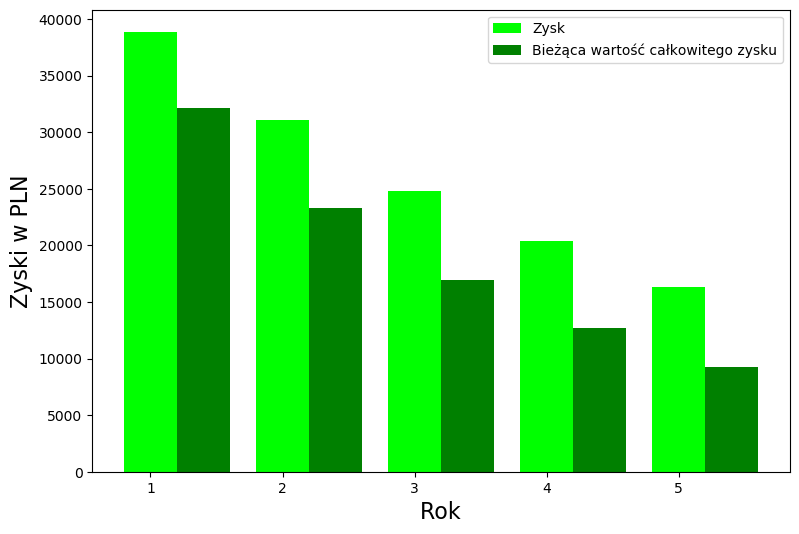

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [16]:
fig, ax = PyPlot.subplots(figsize=(9,6))
PyPlot.bar([i for i in 1:5], profit, width = 0.4, color = "lime", label = "Zysk")
PyPlot.bar([i+0.4 for i in 1:5], pvs, width = 0.4, color = "green", label = "Bieżąca wartość całkowitego zysku")
ax.axis("tight")
ax.set_xlabel("Rok",fontsize=16)
ax.set_ylabel("Zyski w PLN",fontsize=16)
PyPlot.legend()
PyPlot.show()

Ostatnim krokiem symulacji jest uruchomienie 1000 różnych, niezależnych kampanii celem zebrania dużej ilości danych.

In [17]:
cohort_size_list = []
CAC_list = []
CLTV_list = []

for i in 1:1000
    
    
    conversion_rate = get_conversion_rate(conversion_rate_expected, conversion_rate_stdev)
    cohort_size = run_campaign(spend, cpm, conversion_rate)
    CAC = spend/cohort_size
    
    
    customers_left, spending, profit = simulate_group(cohort_size, churn_rate, transactions, price, retention_cost, 5)
    
    cohort_value = sum(present_value(profit, rate))
    
    push!(cohort_size_list, cohort_size)
    push!(CAC_list, CAC)
    push!(CLTV_list, cohort_value/cohort_size)
end

Wygenerowane powyżej dane przechowywane będą w postaci ramki danych. Wyświetlonych zostanie jej 5 pierwszych wierszy.

In [18]:
results_df = DataFrame()
results_df.initial_cohort_size = cohort_size_list
results_df.CLTV = CLTV_list
results_df.CAC = CAC_list
results_df.Spread = results_df.CLTV - results_df.CAC

first(results_df, 5)

,initial_cohort_size,CLTV,CAC,Spread
,Any,Any,Any,Float64
1,711,78.2566,70.3235,7.93308
2,433,78.3497,115.473,-37.1237
3,1522,74.5712,32.8515,41.7197
4,1452,77.1584,34.4353,42.7232
5,853,78.7293,58.6166,20.1126


## Analiza wyników

<p>Pierwszy z wykresów przedstawia rozkład początkowej liczby klientów sklepu:</p>

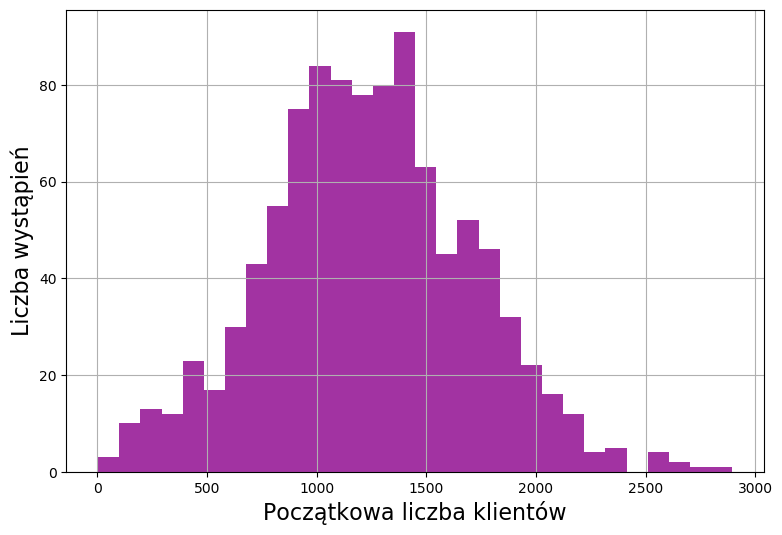

In [19]:
fig, ax = PyPlot.subplots(figsize=(9,6))
PyPlot.hist(results_df.initial_cohort_size, bins=30, alpha=0.8, color="darkmagenta")
ax.grid("on")
ax.set_xlabel("Początkowa liczba klientów",fontsize=16)
ax.set_ylabel("Liczba wystąpień",fontsize=16)

PyPlot.show()

<p>Jak widać, liczba ta może przyjmować duże wielkości. W naszym przykładzie spowodowane jest to m.in. zróżnicowanych wartości wskaźnika konwersji dla każdej kampanii oraz losowości każdego wyświetlenia. Mimo, że większość kampanii skupiona jest w przedziale 500 - 2000 klientów, to istnieje prawdopodobieństwo niemal całkowitego braku zainteresowania klientów ofertą sklepu, jak i bardzo pozytywnego odbioru.</p>

Kolejny wykres prezentuje koszt pozyskania klienta

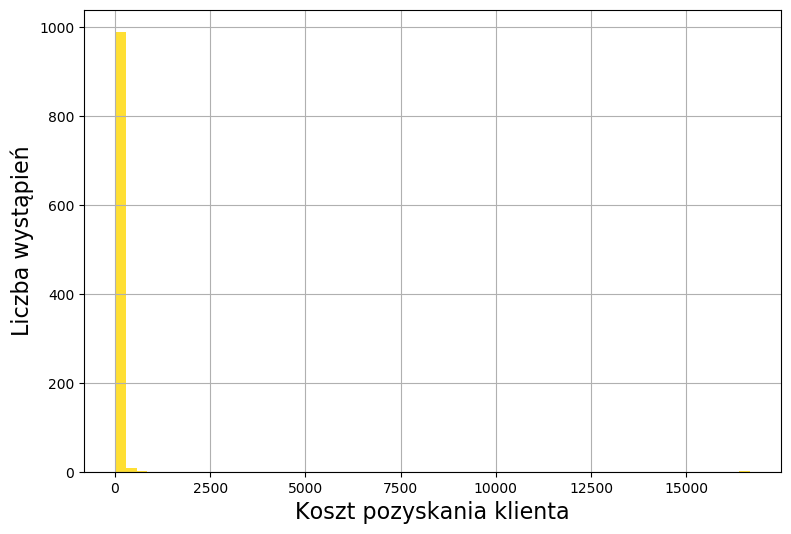

In [20]:
fig, ax = PyPlot.subplots(figsize=(9,6))
PyPlot.hist(results_df.CAC, bins=60, alpha=0.8, color="gold")
ax.grid("on")
ax.set_xlabel("Koszt pozyskania klienta",fontsize=16)
ax.set_ylabel("Liczba wystąpień",fontsize=16)

PyPlot.show()

W zdecydowanej większości przypadków koszt pozyskania klienta oscylował w okolicach kilkudziesięciu złotych. Warto zaznaczyć, że koszt ten maleje wraz z rosnącą liczbą klientów. Dlatego też, widoczna po prawej stronie kwota pozyskania klienta przekraczająca 16 tysięcy złotych z pewnością dotyczy bardzo niekorzystnego przypadku, gdzie kampania internetowa przełożyła się na zaledwie kilku klientów.

Następny wykres przedstawia 5-letnią wartość klienta dla sklepu

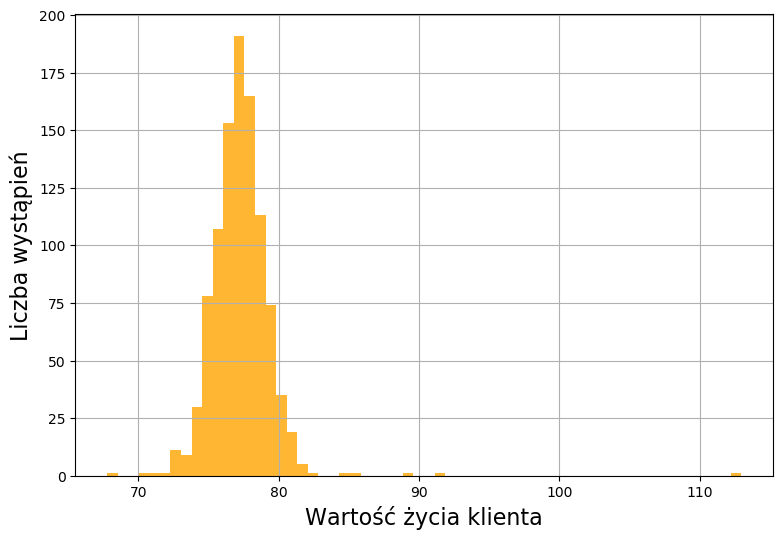

In [21]:
fig, ax = PyPlot.subplots(figsize=(9,6))
PyPlot.hist(results_df.CLTV, bins=60, alpha=0.8, color="orange")
ax.grid("on")
ax.set_xlabel("Wartość życia klienta",fontsize=16)
ax.set_ylabel("Liczba wystąpień",fontsize=16)

PyPlot.show()

Z powyższego histogramu wynika, że w trakcie niemal wszystkich kampanii całkowita wartość klienta dla sklepu rozumiana przez wydawane środki mieściła się w przedziale między 70 a 80 złotych. Możliwe jednak, że wpływ miał na to stały na przestrzeni 5 lat wskaźnik churnu, którego w modelu nie poddano korekcie jak niektóre inne parametry. W efekcie obserwowana jest mała wariancja, z pojedynczymi obserwacjami odstającymi jednak nadal znajdujących się dość blisko wspomnianego przedziału.

Ostatni wykres obrazuje wartość rozstępu między przeciętną wartością klienta a kosztem jego pozyskania.

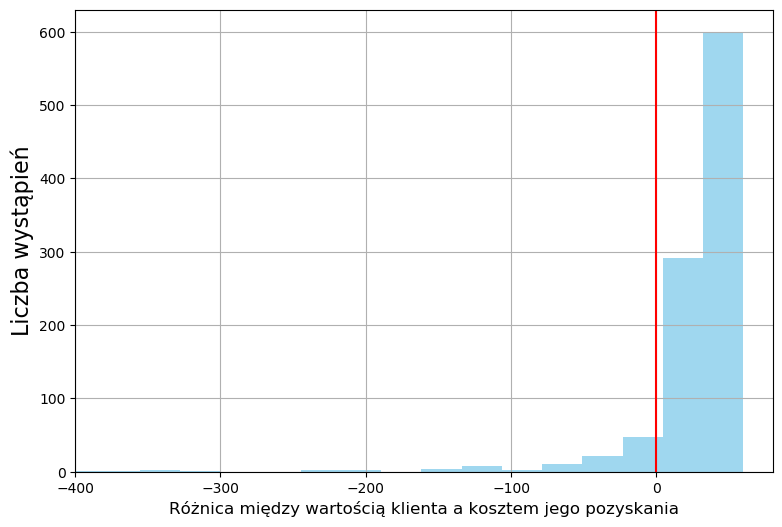

In [28]:
fig, ax = PyPlot.subplots(figsize=(9,6))
PyPlot.hist(results_df.Spread, bins=600, alpha=0.8, color="skyblue")
PyPlot.axvline(x=0, color="red")
PyPlot.xlim(-400, 80)
ax.grid("on")
ax.set_xlabel("Różnica między wartością klienta a kosztem jego pozyskania",fontsize=12)
ax.set_ylabel("Liczba wystąpień",fontsize=16)

PyPlot.show()

Widoczna na wykresie czerwona pionowa linia ustawiona została na wartości 0, tak aby łatwo można było dokonać porównania grup klientów wydających więcej niż wynosił koszt ich pozyskania i tych, których pozyskanie kosztowało więcej niż wydali oni w sklepie. Grafika jasno wskazuje, że osoby o dodatniej wartości <i>Spread</i> stanowią znacznie liczniejszą grupę.

Na zakończenie analizy wygenerowano zbiorczą ramkę danych, umożliwiającą częściowe zweryfikowanie informacji zawartych na wykresach.

In [24]:
describe(results_df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Union…,Union…,DataType
1,initial_cohort_size,1234.74,3,1227.5,2895,756,0,Any
2,CLTV,77.2664,67.7784,77.2301,112.935,1000,0,Any
3,CAC,68.8521,17.2712,40.7332,16666.7,756,0,Any
4,Spread,8.41425,-16553.7,36.3184,59.7575,,,Float64


Dowiadujemy się z niej m.in., że połowa klientów ma wartość <i>Spread</i> wyższą niż 36 zł. W tabeli tej można również stosunkowo łatwo uchwycić widoczne na niektórych wykresach wartości odstające. Zgodnie z powyższymi informacjami, istnieje ryzyko bardzo nieskutecznej internetowej kampanii reklamowej, gdzie zakupy dokonuje garstka klientów, co skutkuje astronomiczną kwotą pozyskania klienta i odwrotnie - kampanii z dużą liczbą klientów, w której koszt rozkłada się na wiele więcej osób i tym samym jest niski.

## Podsumowanie

<p>Przeprowadzona symulacja i uzyskane dzięki niej wyniki nie udzielają jednoznacznej odpowiedzi na pytanie o zasadność zainwestowania środków w internetową kampanię marketingową. Na pewno potrzebne jest ujęcie w modelu większej liczby parametrów mających wpływ na decyzję konsumenta o wyborze danego produktu i sprzedawcy. Badana była jedynie internetowa aktywność sklepu i nie uwzględniono m.in. możliwej sprzedaży stacjonarnej, innych kosztów prowadzenia działalności, a sama prognoza dotyczyła jedynie 5 lat.</p>
<p>Niniejszy projekt miał na celu prezentację alternatywnego względem podejścia stricte analitycznego modelowania symulacyjnego. Na prostym przykładzie metody Monte Carlo pokazano, że jest to niezwykle efektywna kosztowo i czasowo metoda, z pewnością nie pozbawiona wad. W badaniu dokonaliśmy szeregu założeń i uproszczeń, które mogą zniekształcać rzeczywistość i tym samym prowadzić do obarczonych błędem wniosków. Metody symulacyjne wymagają od badacza bardzo dobrej znajomości będącego przedmiotem zainteresowania zjawiska i uwzględnienia wielu parametrów mogących w prawdziwym życiu wpływać na ostateczny wynik przedsięwzięcia. Warto jednak zaznaczyć, że wybór modelowania bazującego na danych historycznych również nie gwarantuje idealnego narzędzia predykcyjnego.</p>